## Import Modules

In [1]:
%matplotlib inline
# %matplotlib notebook

import time
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from urllib.request import urlopen
import pandas_profiling

plt.style.use('ggplot')

/home/debadatta/.local/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# Getting the data

In [2]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases//breast-cancer-wisconsin/wdbc.data'
names = ['id_number', 'diagnosis', 'radius_mean',
         'texture_mean', 'perimeter_mean', 'area_mean',
         'smoothness_mean', 'compactness_mean',
         'concavity_mean','concave_points_mean',
         'symmetry_mean', 'fractal_dimension_mean',
         'radius_se', 'texture_se', 'perimeter_se',
         'area_se', 'smoothness_se', 'compactness_se',
         'concavity_se', 'concave_points_se',
         'symmetry_se', 'fractal_dimension_se',
         'radius_worst', 'texture_worst',
         'perimeter_worst', 'area_worst',
         'smoothness_worst', 'compactness_worst',
         'concavity_worst', 'concave_points_worst',
         'symmetry_worst', 'fractal_dimension_worst']

In [3]:
breast_cancer_data = pd.read_csv(urlopen(url), names=names)

In [4]:
breast_cancer_data.columns

Index(['id_number', 'diagnosis', 'radius_mean', 'texture_mean',
       'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean',
       'concavity_mean', 'concave_points_mean', 'symmetry_mean',
       'fractal_dimension_mean', 'radius_se', 'texture_se', 'perimeter_se',
       'area_se', 'smoothness_se', 'compactness_se', 'concavity_se',
       'concave_points_se', 'symmetry_se', 'fractal_dimension_se',
       'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst',
       'smoothness_worst', 'compactness_worst', 'concavity_worst',
       'concave_points_worst', 'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')

In [5]:
breast_cancer_data.head()

,id_number,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [6]:
breast_cancer_data.profile_report()

## Cleaning

In [7]:
# Diagnosis M=malignant, B=benign
# Converting categorical Column diagnosis into binary M=1, B=0

breast_cancer_data['diagnosis'] = breast_cancer_data['diagnosis'].map({'M':1,'B':0})

In [8]:
# Setting id as index number
breast_cancer_data.set_index(['id_number'], inplace=True)

In [9]:
breast_cancer_data.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
id_number,,,,,,,,,,,,,,,,,,,,,
842302,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
842517,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
84300903,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
84348301,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
84358402,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [10]:
# Check missing values
breast_cancer_data.isnull().sum()

diagnosis                  0
radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave_points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave_points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave_points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
dtype: int64

In [11]:
breast_cancer_data.isnull().sum()

diagnosis                  0
radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave_points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave_points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave_points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
dtype: int64

In [12]:
# .ravel()(numpy) returns contiguous flattened array
# (1D array with all the input-array elements and with the same type as it).
# A copy is made only if needed.
'''
Original array : 
 [[ 0  1  2  3  4]
 [ 5  6  7  8  9]
 [10 11 12 13 14]]

ravel() :  [ 0  1  2 ..., 12 13 14]

'''
# breast_cancer_data['diagnosis'].isnull().values.ravel().


'\nOriginal array : \n [[ 0  1  2  3  4]\n [ 5  6  7  8  9]\n [10 11 12 13 14]]\n\nravel() :  [ 0  1  2 ..., 12 13 14]\n\n'

In [13]:
for column in breast_cancer_data:
    if((breast_cancer_data.isnull().values.ravel().sum)==0):
        pass
    else:
        print(column)
        print(breast_cancer_data[column].isnull().values.ravel().sum())
print('No missing values found')    

diagnosis
0
radius_mean
0
texture_mean
0
perimeter_mean
0
area_mean
0
smoothness_mean
0
compactness_mean
0
concavity_mean
0
concave_points_mean
0
symmetry_mean
0
fractal_dimension_mean
0
radius_se
0
texture_se
0
perimeter_se
0
area_se
0
smoothness_se
0
compactness_se
0
concavity_se
0
concave_points_se
0
symmetry_se
0
fractal_dimension_se
0
radius_worst
0
texture_worst
0
perimeter_worst
0
area_worst
0
smoothness_worst
0
compactness_worst
0
concavity_worst
0
concave_points_worst
0
symmetry_worst
0
fractal_dimension_worst
0
No missing values found


## Dimensions

In [14]:
breast_cancer_data.shape

(569, 31)

In [15]:
breast_cancer_data.dtypes

diagnosis                    int64
radius_mean                float64
texture_mean               float64
perimeter_mean             float64
area_mean                  float64
smoothness_mean            float64
compactness_mean           float64
concavity_mean             float64
concave_points_mean        float64
symmetry_mean              float64
fractal_dimension_mean     float64
radius_se                  float64
texture_se                 float64
perimeter_se               float64
area_se                    float64
smoothness_se              float64
compactness_se             float64
concavity_se               float64
concave_points_se          float64
symmetry_se                float64
fractal_dimension_se       float64
radius_worst               float64
texture_worst              float64
perimeter_worst            float64
area_worst                 float64
smoothness_worst           float64
compactness_worst          float64
concavity_worst            float64
concave_points_worst

# Class Imbalance

The distribution of diagnoses is important because it speaks to class imbalance within machine learning and data mining applications. Class imbalance is a term used to describe when a target class within a data set is outnumbered by another target class (or classes). This can create misleading accuracy metrics, known as an accuracy paradox. To make sure our target classes aren't imbalanced, create a function that will output the distribution of the target classes.

P.S. read on upsampling and downsampling.



## Solution
Undersampling:- it means taking the less number of majority class (In our case taking less number of Normal transactions so that our new data will be balanced

Oversampling: it means using replicating the data of minority class (fraud class) so that we can have a balanced data

SMOTE: it is also a type of oversampling but in this we will make the synthetic example of Minority data and will give as a balanced data



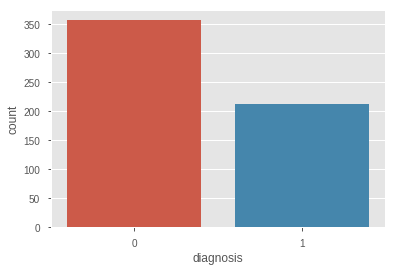

In [19]:
sns.countplot('diagnosis', data=breast_cancer_data)

In [25]:
total = breast_cancer_data['diagnosis'].value_counts()[1] + breast_cancer_data['diagnosis'].value_counts()[0]
print('Malign %: ', (breast_cancer_data['diagnosis'].value_counts()[1]/total)*100)
print('Benign %: ', (breast_cancer_data['diagnosis'].value_counts()[0]/total)*100)

Malign %:  37.258347978910365
Benign %:  62.741652021089635


Benign results account for 62.74% of the diagnosis class. Malignant results account for 37.26% of the diagnosis class. Fortunately, this data set does not suffer from class imbalance.

### Creating Training and Test Sets

Let's split the data set into our training and test sets, which will be pseudo-randomly selected to create a 80-20% split. You will use the training set to train the model and perform some optimization. You will use the test set, which will act as unseen data, to assess model performance.



In [26]:
X = breast_cancer_data.iloc[:, breast_cancer_data.columns != 'diagnosis']
Y = breast_cancer_data.iloc[:, breast_cancer_data.columns == 'diagnosis']

In [27]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.20, random_state=42)

When using this method for machine learning, always be wary of utilizing your test set to create models. Data leakage is a common problem that can result in overfitting.

In [32]:
Y_train = Y_train.values.ravel()
Y_test = Y_test.values.ravel()

## Fitting Random Forest
Now, let's create the model, starting with parameter tuning. Here are the parameters we will be tuning.

### max_depth: 
The maximum splits for all trees in the forest.

### bootstrap: 
An indicator of whether or not we want to use bootstrap samples when building trees.

### max_features: 
The maximum number of features that will be used in node splitting — the main difference I previously mentioned between bagging trees and random forest. Typically, you want a value that is less than p, where p is all features in your data set.

### criterion: 
This is the metric used to asses the stopping criteria for the decision trees.

Once we've instantiated our model, we will go ahead and tune our parameters.